In [1]:
pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [19]:
#IMPORT ALL THE REQUIRED LIBRARIES
import pandas as pd
import numpy as np 
import requests 

from bs4 import BeautifulSoup
import os

from geopy.geocoders import Nominatim 
import requests 
import folium 
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [ ]:
#Extract all the SF Data and Format

In [3]:
source = requests.get('http://www.healthysf.org/bdi/outcomes/zipmap.htm').text
soup=BeautifulSoup(source,'lxml')
table = soup.find_all('table')
sf_data = pd.read_html(str(table))
sf_data = pd.DataFrame(sf_data[4])
sf_data.columns = sf_data.iloc[0] #set the columns equal to the first row
sf_data = sf_data.iloc[1:-1,:-1] #remove rows and columns that are unncessary
sf_data[["Zip Code"]] = sf_data[["Zip Code"]].astype("int")

In [4]:
sf_data.rename(columns = {'Zip Code':'zip_code'}, inplace = True) #prepare for merge
sf_data.head()

,zip_code,Neighborhood
1,94102,Hayes Valley/Tenderloin/North of Market
2,94103,South of Market
3,94107,Potrero Hill
4,94108,Chinatown
5,94109,Polk/Russian Hill (Nob Hill)


In [5]:
us_df=pd.read_csv('http://docs.gaslamp.media/wp-content/uploads/2013/08/zip_codes_states.csv') #read in CSV
us_df.head()

,zip_code,latitude,longitude,city,state,county
0,501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,602,18.393103,-67.180953,Aguada,PR,Aguada
4,603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [6]:
sf_df = pd.merge(sf_data,us_df, on = 'zip_code') #merge data on zip_code
sf_df

,zip_code,Neighborhood,latitude,longitude,city,state,county
0,94102,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,San Francisco,CA,San Francisco
1,94103,South of Market,37.775678,-122.412131,San Francisco,CA,San Francisco
2,94107,Potrero Hill,37.769029,-122.393681,San Francisco,CA,San Francisco
3,94108,Chinatown,37.791028,-122.408782,San Francisco,CA,San Francisco
4,94109,Polk/Russian Hill (Nob Hill),37.795219,-122.420782,San Francisco,CA,San Francisco
5,94110,Inner Mission/Bernal Heights,37.748932,-122.416281,San Francisco,CA,San Francisco
6,94112,Ingelside-Excelsior/Crocker-Amazon,37.721981,-122.439382,San Francisco,CA,San Francisco
7,94114,Castro/Noe Valley,37.758279,-122.439332,San Francisco,CA,San Francisco
8,94115,Western Addition/Japantown,37.786028,-122.437032,San Francisco,CA,San Francisco
9,94116,Parkside/Forest Hill,37.743857,-122.483232,San Francisco,CA,San Francisco


In [7]:
CLIENT_ID = 'U3R4VWEOB5VLT3KEKQAZZWKYBNP5JUCWDGEFVUBN1H2OSUB0' # your Foursquare ID
CLIENT_SECRET = 'Q3GRYC04FD0IJFCC3GWC5D1DZVJNIMPOCA0R5NDU042DUEA0' # your Foursquare Secret
VERSION = '20210509'

In [8]:
def getNearbyVenues(names, latitudes, longitudes): #code from modules used to find nearby venues. 
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
sf_venues = getNearbyVenues(names=sf_df['Neighborhood'],latitudes=sf_df['latitude'],longitudes=sf_df['longitude']) #applied above function to sf data frame to find venues
sf_venues.head()

Hayes Valley/Tenderloin/North of Market
South of Market
Potrero Hill
Chinatown
Polk/Russian Hill (Nob Hill)
Inner Mission/Bernal Heights
Ingelside-Excelsior/Crocker-Amazon
Castro/Noe Valley
Western Addition/Japantown
Parkside/Forest Hill
Haight-Ashbury
Inner Richmond
Outer Richmond
Sunset
Marina
Bayview-Hunters Point
St. Francis Wood/Miraloma/West Portal
Twin Peaks-Glen Park
Lake Merced
North Beach/Chinatown
Visitacion Valley/Sunnydale


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Asian Art Museum,37.780178,-122.416505,Art Museum
1,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Orpheum Theatre,37.779315,-122.414790,Theater
2,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Philz Coffee,37.781266,-122.416901,Coffee Shop
3,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Fermentation Lab,37.778368,-122.415313,Beer Bar
4,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Ananda Fuara,37.777693,-122.416353,Vegetarian / Vegan Restaurant


In [10]:
coffee_data = sf_venues[sf_venues['Venue Category'].isin(['Coffee Shop','Café','Bubble Tea Shop','Bakery'])] #indexed data to find only coffee_related ve
coffee_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Philz Coffee,37.781266,-122.416901,Coffee Shop
9,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Blue Bottle Coffee,37.776286,-122.416867,Coffee Shop
13,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Arsicault Bakery,37.780789,-122.413433,Bakery
19,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Andersen Bread,37.776906,-122.417400,Bakery
46,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,All Star Cafe,37.776325,-122.414764,Café
...,...,...,...,...,...,...,...
1051,North Beach/Chinatown,37.801928,-122.410182,Cavalli Cafe,37.799315,-122.408861,Coffee Shop
1061,North Beach/Chinatown,37.801928,-122.410182,Cafe Francisco,37.804861,-122.411890,Coffee Shop
1063,North Beach/Chinatown,37.801928,-122.410182,DeLise,37.805772,-122.412708,Coffee Shop
1064,North Beach/Chinatown,37.801928,-122.410182,901 Columbus Caffe,37.802829,-122.414023,Café


In [42]:
coffee_to_plot = coffee_data['Neighborhood'].value_counts() #count the number of occurrences of each neighborhood to find the number of venues
print(coffee_to_plot)
neighborhoods = coffee_data['Neighborhood'].value_counts().index.values #extract the name of the of the neighborhoods in order of decreasing num of coffee venues

North Beach/Chinatown                      16
South of Market                            12
Western Addition/Japantown                 10
Chinatown                                   9
Hayes Valley/Tenderloin/North of Market     9
Sunset                                      8
Inner Richmond                              7
Ingelside-Excelsior/Crocker-Amazon          6
Parkside/Forest Hill                        6
Polk/Russian Hill (Nob Hill)                6
Potrero Hill                                5
Outer Richmond                              4
Marina                                      3
Inner Mission/Bernal Heights                3
Castro/Noe Valley                           3
Twin Peaks-Glen Park                        2
Lake Merced                                 2
Haight-Ashbury                              2
Name: Neighborhood, dtype: int64


([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

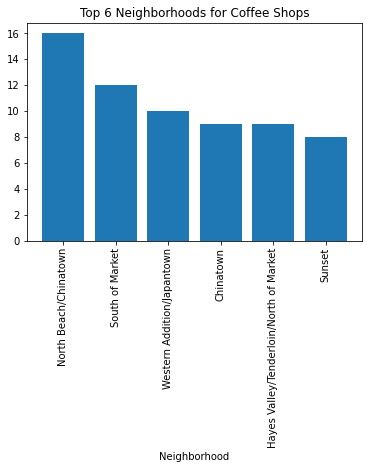

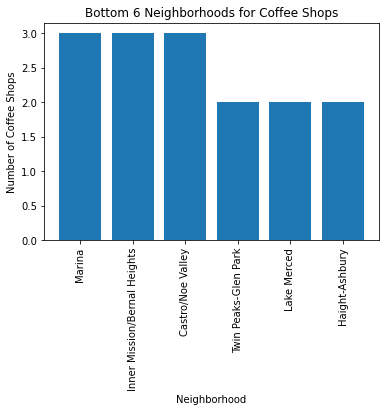

In [44]:
fig1 = plt.figure()
plt.title("Top 6 Neighborhoods for Coffee Shops")
plt.xlabel('Neighborhood')
plt.bar(neighborhoods[:6],coffee_to_plot[:6])
plt.xticks(rotation = 90)

fig2 = plt.figure()
plt.title("Bottom 6 Neighborhoods for Coffee Shops")
plt.ylabel('Number of Coffee Shops')
plt.xlabel('Neighborhood')
plt.bar(neighborhoods[-6:],coffee_to_plot[-6:])
plt.xticks(rotation = 90) 

In [13]:
# one hot encoding
sf_onehot = pd.get_dummies(coffee_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = coffee_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()

In [14]:
# set number of clusters
kclusters = 8

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 4, 2, 3, 7, 2, 0, 7, 2], dtype=int32)

In [15]:
# add clustering labels
sf_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = coffee_data

In [16]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(sf_grouped.set_index('Neighborhood'), on='Neighborhood')

sf_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Bakery,Bubble Tea Shop,Café,Coffee Shop
2,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Philz Coffee,37.781266,-122.416901,Coffee Shop,2,0.222222,0.111111,0.333333,0.333333
9,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Blue Bottle Coffee,37.776286,-122.416867,Coffee Shop,2,0.222222,0.111111,0.333333,0.333333
13,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Arsicault Bakery,37.780789,-122.413433,Bakery,2,0.222222,0.111111,0.333333,0.333333
19,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Andersen Bread,37.776906,-122.417400,Bakery,2,0.222222,0.111111,0.333333,0.333333
46,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,All Star Cafe,37.776325,-122.414764,Café,2,0.222222,0.111111,0.333333,0.333333


In [17]:
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.419906.


In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, venue, poi, cluster in zip(sf_merged['Venue Latitude'], sf_merged['Venue Longitude'], sf_merged['Venue Category'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters